# Deep Learning with Python
# 6.4.0 - Advanced RNNs

Will be using three different techniques to improve RNN performance on a **sequence regression** task - predicting the temperature using past values of temperature, pressure, wind, and other climate data.

These techniques are
1. Recurrent Dropout - a specific, built-in way to use dropout to fight overfitting in recurrent layers.
2. Stacking recurrent layers - increases the representational power of the network (albeit at the cost of higher computational complexity).
3. Bidirectional recurrent layers - present same information to recurrent network in different ways, increasing accuracy and mitigating overfitting.

## Loading Temperature Data
Reading dataset with sensor readings for temperature, pressure, humidity, wind speed, etc. from 2009 - 2016. Assumes the data is stored in a CSV file in the same directory as the notebook.

In [1]:
import os 

In [2]:
data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
# Open the file, read its data, and close filestream
f = open(fname)
data = f.read()
f.close()

The data we just read is a massive blob of CSV values. Need to process it by
- splitting the data into individual records or lines
- removing the header with the column names from the data
- splitting each line into individual values based on the comma delimiter.
- reading each line into a `numpy` array.

In [4]:
# Split into individual lines - each new entry begins on a new line
lines = data.split('\n')

In [5]:
# The first line in the list of lines will be the header or column names
header = lines[0].split(',')

In [6]:
# All remaining lines are training examples
lines = lines[1:]

In [7]:
# What are the features in this dataset?
print(header)
print("Number of columns in header: ", len(header))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of columns in header:  15


In [8]:
# What is the number of training examples?
print("Number of lines: ", len(lines))

Number of lines:  420551


So the dataset consists of 420,551 different timesteps with 14 weather-related features recorded at each timestep. 

To read into a `numpy` array, can't just cast the `lines` to a `numpy` array. Will need to parse line by line and convert each number to a float that is then inserted in the right position in a previously initialized array.

In [9]:
import numpy as np

In [10]:
# Create array of zeros to store feature values for all training samples
float_data = np.zeros((len(lines), len(header) - 1)) 

# Enumerating because we want to associate an index with each line
for i, line in enumerate(lines):
    # Split each line into list of comma-separated values and convert all except timestep to np.float
    values = [float(x) for x in line.split(',')[1:]]
    
    # Append to the right row in the np array
    float_data[i, :] = values

### Plotting Temperature

In [11]:
from matplotlib import pyplot as plt

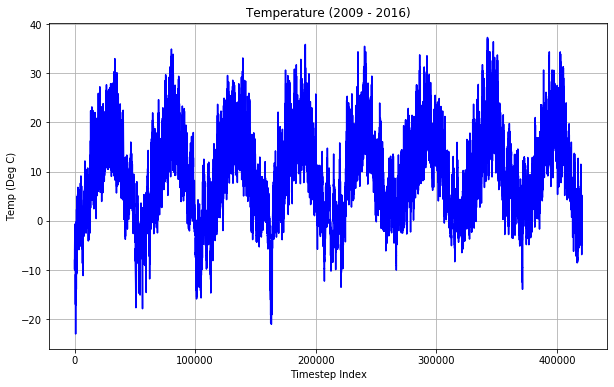

In [12]:
temp = float_data[:, 1] # Temperature is in degrees Celsisu
plt.figure(figsize=(10, 6))
plt.plot(range(len(temp)), temp, 'blue')
plt.grid(True); plt.xlabel('Timestep Index'); plt.ylabel('Temp (Deg C)');
plt.title('Temperature (2009 - 2016)');

In [13]:
# Can also plot data for the first 10 days
sampling_time_minutes = 10
minutes_per_hour = 60
samples_per_hour = minutes_per_hour / sampling_time_minutes
hours_per_day = 24
samples_per_day = int(samples_per_hour * hours_per_day)
days = 10
total_samples = int(days * samples_per_day)
print(f"Samples in one day: {samples_per_day}")
print(f"In {days} days, there will be {total_samples} samples.")

Samples in one day: 144
In 10 days, there will be 1440 samples.


Text(0.5, 1.0, 'Temperature (First 10 days)')

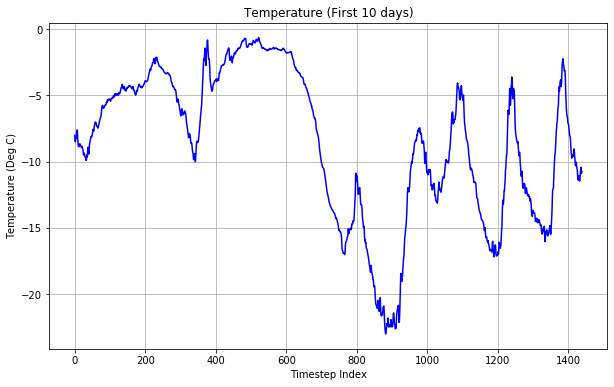

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(total_samples), float_data[:total_samples, 1], 'blue')
plt.grid(True); plt.xlabel('Timestep Index'); plt.ylabel('Temperature (Deg C)');
plt.title('Temperature (First 10 days)')

### Discussion
- The temperature plot for the entire duration shows a clear periodicity in the temperature readings: temperature always rises and falls, almost sinusoidally, between peaks and troughs.
- The average temperature seems to have increased over the years, as the graph from 2009 - 2016 is moving upwards with time.
- There is not as much periodicity in the temperature of the first 10 days. 
- The temperature in the first 10 days was clearly from a winter month because the minimum temperature is ~-25 degrees. 

## Preprocessing Data
### Formulating the Problem
Given data going as far back as `lookback` timesteps (each timestep is 10 minutes in this case) and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps? 

Specifically, we'll be using the following values for each of these parameters
- `lookback`: 720 - There are 144 samples in a day, so 720 samples represents data for 720 / 144 = **5 days**.
- `steps`: 6 - observations will be sampled at one data point per hour, instead of using all 10 data points per hour.
- `delay`: 144 - the data will be used to predict the temperature 144 samples i.e. 1 day later. 

### Processing
- **Train-test-val split**: separate the training, test, and validation data prior to any further processing.
- **Feature Scaling**: temperature, pressure, humidity, etc. all occupy different ranges of values. They need to be scaled so that all features will occupy the same range of values. Each timeseries will be normalized independently, which means all temperature, pressure, wind speed, etc. columns will be normalized.
- **Generator Definition**: we will instantiate a Python generator that will parse the float data array and yield batches of data from the recent past along with a target temperature 24 hours later. There will be a lot of overlap between successive "windows" of data (i.e. sample N and N + 1 will have all but 1 unique set of readings reading at 1 timestep, rest will be the same). This is why its better to generate this data on the fly. 

### Training Data Normalization

In [15]:
# Number of samples to use for training 
num_train_samples = 200000

In [16]:
# Calculate the mean and st of all rows for each column (feature) in the dataset
# This means calculate these vals for temperature, wind speed, pressure, rainfall, etc.
mean = float_data[:num_train_samples].mean(axis=0)
std = float_data[:num_train_samples].std(axis=0)

In [17]:
# Standard Scaling of entire dataset using only training mean and deviation
float_data -= mean
float_data /= std

In [18]:
import pandas as pd
pd.DataFrame(data=float_data).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,0.038491,0.042112,0.038693,0.070795,0.039110,0.025139,0.056407,-0.008988,0.055220,0.055270,-0.034163,-0.292048,-0.220088,-0.017010
std,0.985619,0.951524,0.949876,0.939271,0.984986,1.006486,0.996685,1.011674,0.996432,0.996080,0.940840,42.590113,29.612448,1.000790
min,-8.877654,-3.624666,-3.635143,-4.110963,-3.730668,-1.616949,-2.026391,-0.844138,-2.016473,-2.023773,-3.720137,-6508.350427,-4291.708700,-2.034528
25%,-0.552608,-0.645846,-0.638463,-0.587306,-0.606437,-0.728684,-0.735325,-0.664398,-0.733484,-0.732635,-0.706640,-0.755535,-0.776389,-0.592485
50%,0.081793,0.038707,0.036153,0.107657,0.235898,-0.203268,-0.104085,-0.391691,-0.106995,-0.104704,-0.087654,-0.254450,-0.261516,0.252652
75%,0.687894,0.722130,0.713003,0.784478,0.839701,0.548441,0.727248,0.250826,0.722071,0.725481,0.594408,0.461387,0.502212,0.668292
max,3.120553,3.185841,3.148992,2.604220,1.473395,6.553010,4.531366,8.661384,4.597300,4.565969,4.142869,17.140369,8.551389,2.121881


### Generator
Will yield `(samples, targets)` tuple where `samples` is a batch of input data and `targets` is the corresponding array of target temperatures. 

The generator requires the following arguments
- `data`: the original array of floating point data what we just normalized
- `lookback`: how many timesteps into the past should the input data go
- `delay`: how many timesteps into the future should the target be
- `min_index` and `max_index`: indices in the `data` array that delimit the timesteps to draw data from. This is useful because we can keep a segment of the data fro validation and another for testing.
- `shuffle`: whether to shuffle the samples or draw them in chronological order.
- `batch_size`: how many samples to draw per batch 
- `step`: the period, in timesteps, at which you sample data. This will be set to 6 so that we will draw only one of 6 data points each hour (instead of available 10 data points per hour).

In [19]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """Yields batchs of weather timeseries data along with their respective target temperatures"""
    # If no max_index has been specified, assume it is last idx for which prediction can be made
    # This means it is idx that is `delay` timesteps before last idx of array
    if max_index is None:
        max_index = len(data) - delay - 1
    
    # idx of the current timestep that will be used for making predictions
    # Initialised to first timestep that can be used to make predictions i.e. the first timestep
    # for which at least `lookback` other timesteps are available
    i = min_index + lookback
    
    # Loops indefinitely to continuously yield batches of data
    while 1:
        if shuffle:
            # `batch_size` random, non-sequential idxs between first and last idx that can be used
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
            
        # If shuffle not set, draw idxs sequentially
        else:
            # If drawing `batch_size` samples from current idx exceed max prediction index
            if i + batch_size >= max_index:
                # Reset the generators index to the first allowable index 
                i = min_index + lookback
            
            # Create sequence of idxs from current idx to either end of batch or end of dataset
            # Upper bound will be the one that doesn't exceed the max allowable idx for prediction
            rows = np.arange(i, min(i + batch_size, max_index))
            
            # Increment the batch's starting index for next generation
            i += len(rows)
        
        # Create numpy array to hold batch data
        samples = np.zeros((len(rows),              # One row per each timestep
                           lookback // step,        # Not sure why
                           data.shape[-1]))         # Number of features 
        
        # Create numpy array to hold predicted temperatures for each timestep
        targets = np.zeros((len(rows), ))
        
        # Extract data from the array
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        # Return the current batch of input data
        yield samples, targets

### Creating Generators
Will create different generators for training, testing, and validation. This ensures that data yielded by a generator during training won't be used during validation or testing. 

In [20]:
lookback = 1440     # 10 days of data
step = 6            # Sampled once every hour 
delay = 144         # Predictions made for 24 hrs later
batch_size = 128    # number of timesteps in each batch

In [21]:
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0,
                      max_index=num_train_samples, shuffle=True, step=step, batch_size=batch_size)

In [22]:
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=num_train_samples + 1, 
                   max_index=300000, step=step, batch_size=batch_size)

In [23]:
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, 
                    max_index=None, step=step, batch_size=batch_size)

In [24]:
# How many batches or steps to draw from val_gen to see entire validation set?
val_steps = (300000 - 200001 - lookback)
val_steps

98559

In [25]:
# How many batches or steps to draw from test_gen to see entire test set?
test_steps = (len(float_data) - 300001 - lookback)
test_steps

119110

### Non-ML Baseline
We need to establish a common sense, non-machine learning baseline against which we can compare our ML model's performance. In other words, we need an approximate measure of loss for a simple method of solving a problem using non-ML approaches which will need to be either matched or improved to justify the use of ML and other advanced approaches.

Since temperature values are continuous, and there is periodicity in the temperature, we can simply predict that temperature 24 hours from a given time `t_0` will just be equal to the current temperature `T(t_0)`. We then need to find the loss or error that is achieved using this approach.

In [108]:
def evaluate_naive_method():
    # Will store the mean absolute error for each batch of samples in a list
    batch_maes = []
    
    # For each possible batch that can be drawn while parsing the validation set once
    for step in range(val_steps):
        if (step % 5000 == 0):
            print(".")
            
        # Get next batch of samples and corresponding target temperature from validation generator
        samples, targets = next(val_gen)
        
        # Predicted temperature is the same as current temperature
        # Last index along second axis is the current day
        preds = samples[:, -1, 1]
        
        # Compute mean absolute error
        mae = np.mean(np.abs(preds - targets))
        
        # Append the MAE for this batch to the lit
        batch_maes.append(mae)
        
    # Output the mean of all batch mean absolute errors
    print("Overall MAE across all batches = ", np.mean(batch_maes))

In [109]:
print(f"Number of batches to be drawn from validation set: {val_steps}")

Number of batches to be drawn from validation set: 98559


In [110]:
evaluate_naive_method()

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Overall MAE across all batches =  0.28969941979609787


The book's mean absolute error using then naive approach is 0.29. This does not mean that the difference in predicted and actual temperature using the naive approach is 0.29 degrees Celsius. The temperature values have been normalized to have mean of 0 and standard deviation of 1, so the value is not directly interpretable. It is actually equal to 0.29 * `temperature_std` degrees i.e. 2.57 degrees, which is a fairly large absolute error.

My mean absolute error is approximately the same, which makes sense because the validation data generator does not shuffle data, so there is no randomness involved in the order in which samples are drawn for MAE calculation.

In [117]:
celsius_mae = 0.2896994 * std[1] # Using standard deviation of temperature only
print(celsius_mae)

2.5645636726152268


## Basic Machine Learning Approach
Before using a computationally expensive deep learning model to solve this problem, it is a good idea to use a simple, straightforward machine learning approach such as a simple feedforward DNN to see if the additional complexity of RNNs will actually yield any benefits.

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [123]:
# Instantiate a simple feedforward model
model = Sequential()

# Input is a timestep with 14 features. There will be `lookback / step` timesteps in a batch. 
# Each batch will be fed to neural network.
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(), loss='mae')

In [125]:
# Record history
basic_dnn_history = model.fit(train_gen, 
                             steps_per_epoch=500, # 500 batches drawn per epoch!
                             epochs=20, 
                             validation_data=val_gen, 
                             validation_steps=500) # Limiting validation steps because it takes too long to train 

Train for 500 steps, validate for 500 steps
Epoch 1/20
500/500 [==============================] - 12s 25ms/step - loss: 1.4758 - val_loss: 0.9017
Epoch 2/20
500/500 [==============================] - 12s 25ms/step - loss: 0.5892 - val_loss: 0.4560
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3268 - val_loss: 0.3185
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2765 - val_loss: 0.3032
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2564 - val_loss: 0.3125
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2470 - val_loss: 0.3151
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2389 - val_loss: 0.3236
Epoch 8/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2328 - val_loss: 0.3114
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2278 - val_loss: 0.3257
Epoch 10/20
500/500 [=================

### Displaying Basic Model's Loss Curves

In [126]:
import matplotlib.pyplot as plt 

In [127]:
# Extracting data from history obj
loss = basic_dnn_history.history['loss']
val_loss = basic_dnn_history.history['val_loss']
epochs = range(1, len(loss) + 1)

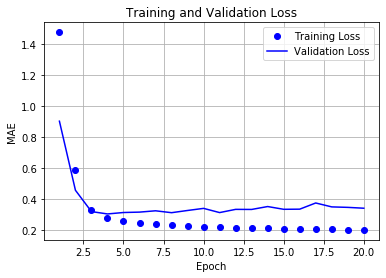

In [128]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

### Interpretation
- The results are significantly different from those in the book because I have drawn far fewer batches of samples and targets from the validation generator. 
- The results converge to a loss that is above that predicted by the naive baseline.
- This is important because it shows
    - A simple, non-ML method to map data to targets exists: simply predict tomorrow's temperature to be the same as today's temperature.
    - This simple approach outperforms the basic ML approach or, in other words, is a difficult baseline to beat.
    - Even though the `T(t_(n+1)) = T(t_0)` mapping is technically part of the hypothesis space formed by the two layer feedforward deep neural network we have defined, it has not been learnt by the deep learning model.
- **In a hypothesis space of complicated models, the simple, well-performing baseline may be unlearnable, even if it is technically a part of the hypothesis space**.

## First Recurrent Baseline

The reason the basic ML approach did not work well was because it flattened the data prior to feeding it into the network, thereby removing any notion of sequence, causality, or time-related inference. To fix this, we'll use `GRU` or **Gated Recurrent Unit** layers, which are a computationally cheaper (but less powerful) version of LSTM.

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU 
from tensorflow.keras.optimizers import RMSprop

In [135]:
model = Sequential()
model.add(layers.GRU(units=32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [136]:
model.compile(optimizer=RMSprop(), loss='mae')

In [137]:
recurrent_baseline_history = model.fit_generator(train_gen,
                                                steps_per_epoch=100,
                                                epochs=20,
                                                validation_data=val_gen, 
                                                validation_steps=100)

Epoch 1/20
100/100 [==============================] - 106s 1s/step - loss: 0.3718 - val_loss: 0.2820
Epoch 2/20
100/100 [==============================] - 105s 1s/step - loss: 0.2999 - val_loss: 0.2511
Epoch 3/20
100/100 [==============================] - 108s 1s/step - loss: 0.2956 - val_loss: 0.3100
Epoch 4/20
100/100 [==============================] - 107s 1s/step - loss: 0.2941 - val_loss: 0.2762
Epoch 5/20
100/100 [==============================] - 105s 1s/step - loss: 0.2870 - val_loss: 0.3030
Epoch 6/20
100/100 [==============================] - 104s 1s/step - loss: 0.2880 - val_loss: 0.2420
Epoch 7/20
100/100 [==============================] - 109s 1s/step - loss: 0.2888 - val_loss: 0.2499
Epoch 8/20
100/100 [==============================] - 103s 1s/step - loss: 0.2848 - val_loss: 0.2888
Epoch 9/20
100/100 [==============================] - 87s 874ms/step - loss: 0.2811 - val_loss: 0.2455
Epoch 10/20
100/100 [==============================] - 87s 871ms/step - loss: 0.2777 - va

Even though this is supposed to be a cheaper model to train, it is taking a **long** time - minutes instead of seconds per epoch.

This is why I've decided to train for fewer steps per epoch. 

### Plotting Loss Curves - Recurrent Baseline

In [142]:
# Extracting data
recurrent_base_data = recurrent_baseline_history.history
epochs = range(1, len(recurrent_base_data['loss']) + 1)
loss = recurrent_base_data['loss']
val_loss = recurrent_base_data['val_loss']

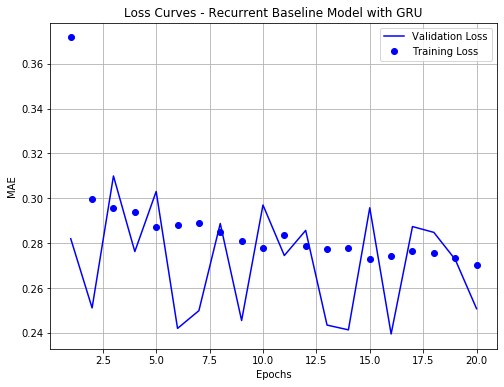

In [143]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.xlabel('Epochs'); plt.ylabel('MAE'); plt.title('Loss Curves - Recurrent Baseline Model with GRU')
plt.grid(True); plt.legend()

### Interpretation

Performance on the validation set is very noisy because I trained for fewer steps per epoch to speed things up. However, the overal trend is the same as described in the book: the validation loss and training loss are both significantly lower for the recurrent baseline model compared to the feedforward baseline model. This improvement is due to the GRU interpreting each sample as part of a sequence and by remembering previous states when computing activations for next timestep. 

## GRU with Dropout
Dropout is a technique that helps fight overfitting by randomly changing inputs of a specific portion of neurons in a layer to zero. This breaks the propagation of happenstance correlations and thus prevents these correlations from affecting the weights of the model through backpropagation. 

Dropout in recurrent/LSTM/GRU layers is applied differently
- Using dropout **before** a recurrent layer has been shown to actually worsen performance.
- Performance does not improve if the inputs that are zeroed by dropout change between different samples (or timesteps). The **same inputs must be zeroed out at all timesteps** i.e. use the **same dropout mask**.
- Also use the **same recurrent dropout mask** i.e. the same inputs must be dropped while computing the inner recurrent activations (W, U, V dot products?). 
- This allows the network to proprly propagate its learning error through time. Random dropout masks would disrupt this error signal and be harmful to the learning process.

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mse')

In [50]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
  3/500 [..............................] - ETA: 10:28 - loss: nan

KeyboardInterrupt: 